# Explore Pole Emploi STMT Data

STMT is statistical data from Pole Emploi about the population of jobseekers. There are four excel workbooks, each with many sheets. This notebook parses and explores them with some basic summary statistics.

Author: Everett, `everett@bayesimpact.org`

---
## Imports and constants
---

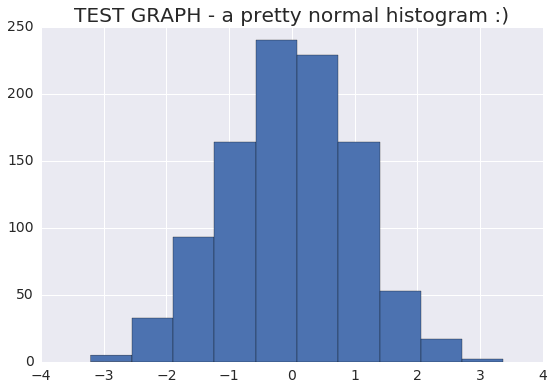

In [1]:
####################################################
# Boilerplate import/setup code for general analysis
####################################################

import datetime as dt
import os
import random

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', 500)
# sns.set_palette(sns.color_palette("cubehelix", 8))
plt.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Fresh imports, constants
import collections
#import mplleaflet
import xlrd
from xlrd.sheet import ctype_text

FILE_ANNUAL = '../../data/stmt/annual_2014.xls'
FILE_MONTHLY = '../../data/stmt/monthly_demand.xls'
FILE_RSA = '../../data/stmt/rsa.xls'
FILE_JOB_POSTS = '../../data/stmt/job_posts.xls'

# book_annual = xlrd.open_workbook(FILE_ANNUAL)
# book_monthly = xlrd.open_workbook(FILE_MONTHLY)
# book_rsa = xlrd.open_workbook(FILE_RSA)
# book_job_posts = xlrd.open_workbook(FILE_JOB_POSTS)

# Sanity check
fig, ax = plt.subplots(1)
ax.set_title('TEST GRAPH - a pretty normal histogram :)')
ax.hist(np.random.randn(1000))
pass

####################################################
# everett@bayesimpact.org
####################################################

---
## Utility code

For loading and working with excel workbooks, and translating languages

---

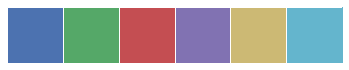

In [2]:
sns.palplot(sns.color_palette())

In [3]:
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_LIGHTBLUE = sns.color_palette()

In [4]:
def print_entire_sheet(xl_sheet):
    num_cols = xl_sheet.ncols   # Number of columns
    for row_idx in range(0, xl_sheet.nrows):    # Iterate through rows
        print ('-'*40)
        print ('Row: %s' % row_idx)   # Print row number
        for col_idx in range(0, num_cols):  # Iterate through columns
            cell_obj = xl_sheet.cell(row_idx, col_idx)  # Get cell object by row, col
            print ('Column: [%s] cell_obj: [%s]' % (col_idx, cell_obj))

In [5]:
for f in [FILE_ANNUAL, FILE_MONTHLY, FILE_RSA, FILE_JOB_POSTS]:
    book = xlrd.open_workbook(f)
    sheets = book.sheet_names()
    print('Found %d sheets in %s' % (len(sheets), f))
    for i,s in enumerate(sheets):
#         print(' ', i, s)
        print('    u"%s": "",' % s)

Found 19 sheets in ../../data/stmt/annual_2014.xls
    u"Sommaire": "",
    u"Chiffres Clés": "",
    u"Reg_sexe": "",
    u"Reg_age": "",
    u"Reg_anc": "",
    u"Reg_form": "",
    u"Reg_qualif": "",
    u"Métier_sexe": "",
    u"Métier_âge": "",
    u"DEE_reg_sexe": "",
    u"DEE_reg_age": "",
    u"DEE_reg_motif": "",
    u"DES_reg_sexe": "",
    u"DES_reg_age": "",
    u"DES_reg_motif": "",
    u"Def_STMT": "",
    u"Def_Cat": "",
    u"Def_Anc": "",
    u"Def_Flux": "",
Found 9 sheets in ../../data/stmt/monthly_demand.xls
    u"Descriptif": "",
    u"Entrées cat ABC_motif": "",
    u"Sorties cat ABC_motif": "",
    u"DEFM cat A_age": "",
    u"DEFM cat B_age": "",
    u"DEFM cat C_age": "",
    u"DEFM cat ABC_age": "",
    u"DEFM cat ABCDE": "",
    u"DELD cat ABC_ancienneté": "",
Found 7 sheets in ../../data/stmt/rsa.xls
    u"Sommaire": "",
    u"Droits ouverts RSA": "",
    u"Droits payables RSA": "",
    u"Composante RSA": "",
    u"Depts droits ouverts": "",
    u"Depts dro

In [6]:
TO_ENGLISH = {
    # Annual book
    u'Chiffres Cl\xe9s': 'key figures',
    u'DEE_reg_age': 'entries: region x age',
    u'DEE_reg_motif': 'entries: region x reason',
    u'DEE_reg_sexe': 'entries: region x sex',
    u'DES_reg_age': 'exits: region x age ',
    u'DES_reg_motif': 'exits: region x reason',
    u'DES_reg_sexe': 'exits: region x sex',
    u'M\xe9tier_sexe': 'category x job x sex',
    u'M\xe9tier_\xe2ge': 'category x job x age',
    u'Reg_age': 'category x region x age',
    u'Reg_anc': 'region x length of unemployment',
    u'Reg_form': 'category x region x education',
    u'Reg_qualif': 'category x region x qualifications',
    u'Reg_sexe': 'category x region x sex',
    # Montly book
    u"Entrées cat ABC_motif": "monthly entries: cat ABC by reason",
    u"Sorties cat ABC_motif": "monthly exits: cat ABC by reason",
    u"DEFM cat A_age": "monthly: cat A by age x gender",
    u"DEFM cat B_age": "monthly: cat B by age x gender",
    u"DEFM cat C_age": "monthly: cat C by age x gender",
    u"DEFM cat ABC_age": "monthly: cat ABC by age x gender",
    u"DEFM cat ABCDE": "monthly: by category x major region",
    u"DELD cat ABC_ancienneté": "monthly: cat ABC by length of unemployment",
#     # RSA book
#     u"Droits ouverts RSA": "",
#     u"Droits payables RSA": "",
#     u"Composante RSA": "",
#     u"Depts droits ouverts": "",
#     u"Depts droits payables": "",
#     u"Structure depts": "",
#     # JOB_POSTS book
#     u"OEE": "",
}
TO_FRENCH = dict((v,k) for k,v in TO_ENGLISH.items())

In [7]:
def read_sheet(name, filename, debug=False):
    '''It takes a bit of work to pull the dataframe out of a sheet.
    
    Mostly because there is extra text with information, and columns have two
    levels of specificity.
    '''
    book = xlrd.open_workbook(filename)
    name = TO_FRENCH.get(name, name)
    s = book.sheet_by_name(name)
    # Find the first row in col 1 with numerical data
    start = 0
    while ctype_text[s.cell(start, 1).ctype] != 'number':
        start += 1
    first_numeric = start
    # ...but the first row(s) may be empty
    while not s.cell(start - 1, 1).value:
        start -= 1
    end = first_numeric
    while s.cell(end, 0).value:
        end += 1
        if end >= s.nrows:
            break
    if debug:
        print('First numeric row: %d, last row: %d, total %d rows x %d cols' % (start+1, end+1, s.nrows, s.ncols))
    footer = s.nrows - end
    col_nested = False
    if s.cell(start - 2, 1).value:
        col_nested = True
    if not col_nested:
        if debug:
            print('Only one level of headers')
        return pd.read_excel(
            filename, sheetname=name, skiprows=start-1, skipfooter=footer, index_col=0)
    level_1 = [s.cell(start - 2, 1).value]
    level_2 = [s.cell(start - 1, 1).value]
    c = 1
    blanks = 0
    while True:
        c += 1
        if c >= s.ncols:
            break
        next1 = s.cell(start - 2, c).value
        next2 = s.cell(start - 1, c).value
        if not next2:
            blanks += 1
            if blanks > 1:
                break
        else:
            blanks = 0
        if not next1:
            next1 = level_1[-1]
        level_1.append(next1)
        level_2.append(next2)
    if debug:
        print('Two levels of columns:')
        print('L1 (%d items):' % len(level_1), level_1)
        print('L2 (%d items):' % len(level_2), level_2)
    df = pd.read_excel(
        filename, sheetname=name, skiprows=start, skipfooter=footer, index_col=0, header=None)
    df.columns = [level_1, level_2]
    return df

In [8]:
# import geopandas as gpd

# REGIONS = '../../data/geo/regions.geojson'
# DEPTS = '../../data/geo/departements.geojson'
# gdf = gpd.read_file(REGIONS)
# gdf['value'] = np.random.randn(len(gdf))
# gdf.set_value(0, 'value', 5)
# gdf.head()

# fig, ax = plt.subplots(1)
# ax = gdf.plot(column='value', colormap='OrRd')
# mplleaflet.display(fig=ax.figure, crs=gdf.crs)

In [9]:
def make_normalized_ticklabels(values):
    exp = ((1e9, ' B'), (1e6, ' M'), (1e3, 'k'))
    key = values[-1]
    for order, symbol in exp:
        if key >= order:
            fmt = '%.1f%s'
            if key >= (10 * order):
                fmt = '%.0f%s'
            return [fmt % (t / order, symbol) for t in values]

def normalize_xticklabels(ax):
    ax.set_xticklabels(make_normalized_ticklabels(ax.get_xticks()))

def normalize_yticklabels(ax):
    ax.set_yticklabels(make_normalized_ticklabels(ax.get_yticks()))

---
# ANALYSIS START
---
## Explore annual data (2014)

In [10]:
df = read_sheet('key figures', FILE_ANNUAL)
df.head()

Catégorie A,B,C,D,E                     dont catégorie A,B,C  \
                             Nombre Répartition\n(en %)               Nombre   
0                                                                              
Alsace                       160436            2.550557               144425   
Aquitaine                    323324            5.140096               283608   
Auvergne                     115513            1.836387               102204   
Basse-Normandie              126330            2.008352               113449   
Bourgogne                    136999            2.177964               123379   

                                    dont catégorie A                      \
                Répartition\n(en %)           Nombre Répartition\n(en %)   
0                                                                          
Alsace                     2.581923            98079            2.571806   
Aquitaine                  5.070132           186454            4.889155   
Auvergne                   1.827127            64233            1.684303   
Basse-Normandie            2.028157            71103            1.864447   
Bourgogne                  2.205678            77973            2.044591   

                Caractéristiques des demandeurs d'emploi \nde catégorie A, B, C  \
                                                         Part des femmes (en %)   
0                                                                                 
Alsace                                                   47.485546                
Aquitaine                                                52.383924                
Auvergne                                                 52.013620                
Basse-Normandie                                          50.129133                
Bourgogne                                                50.822263                

                                                   \
                Part des moins de 25 ans \n(en %)   
0                                                   
Alsace                                  16.005539   
Aquitaine                               15.540464   
Auvergne                                16.428907   
Basse-Normandie                         18.800518   
Bourgogne                               17.294677   

                                                                                     
                Part des demandeurs d'emploi inscrits depuis un an ou plus \n(en %)  
0                                                                                    
Alsace                                                   42.573654                   
Aquitaine                                                40.459014                   
Auvergne                                                 45.527572                   
Basse-Normandie                                          42.164321                   
Bourgogne                                                43.986416

In [11]:
category_rename = {
    'A' : 'A (Unemployed, 0 hrs/mo)',
    'B' : 'B (Heavily Underemployed, 1-78 hrs/mo)',
    'C' : 'C (Underemployed, 78-110 hrs/mo)',
}

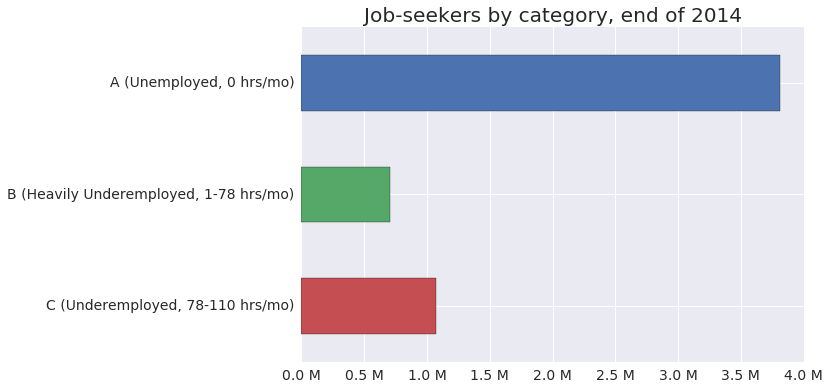

In [12]:
df = read_sheet('category x region x sex', FILE_ANNUAL)
s = df['Total'].ix['France',:'C']
s.index=[category_rename[x] for x in s.index]
fig, ax = plt.subplots(1)
color = sns.color_palette()
s[::-1].plot(kind='barh', color=[color[2], color[1], color[0]], ax=ax)
normalize_xticklabels(ax)
ax.set_title('Job-seekers by category, end of 2014')
pass

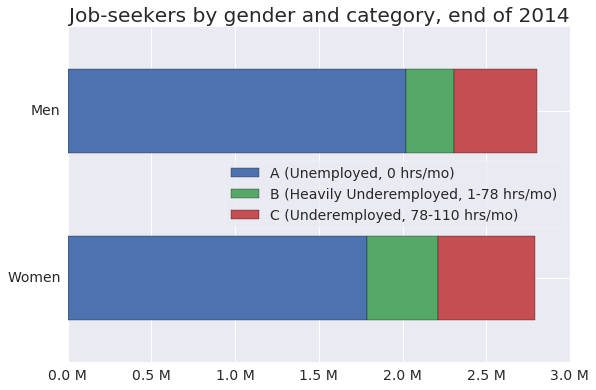

In [13]:
df = read_sheet('category x region x sex', FILE_ANNUAL)
df = df.ix['France',:].unstack()
df = df.ix[:-1, :'C']
df.columns = [category_rename[c] for c in df.columns]
df.index = ['Women', 'Men']
fig, ax = plt.subplots(1)
df.plot(ax=ax, kind='barh', stacked=True, color=sns.color_palette())
normalize_xticklabels(ax)
ax.set_title('Job-seekers by gender and category, end of 2014')
pass

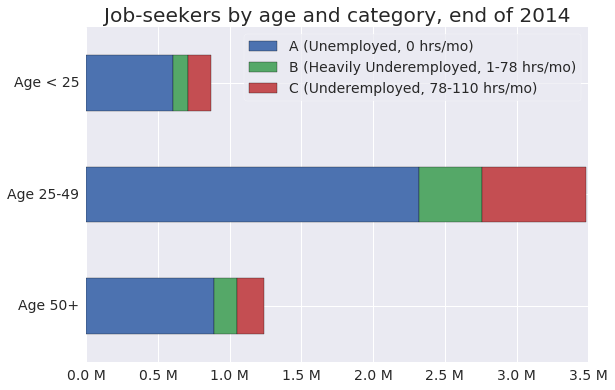

In [14]:
df = read_sheet('category x region x age', FILE_ANNUAL)
df = df.ix['France',:].unstack()
df = df.ix[['Moins de 25 ans', '25-49 ans', '50 ans ou plus'], :'C']
df.index = ['Age < 25', 'Age 25-49', 'Age 50+']
df.columns = [category_rename[c] for c in df.columns]
fig, ax = plt.subplots(1)
df[::-1].plot(ax=ax, kind='barh', stacked=True, color=sns.color_palette())
normalize_xticklabels(ax)
ax.set_title('Job-seekers by age and category, end of 2014')
pass

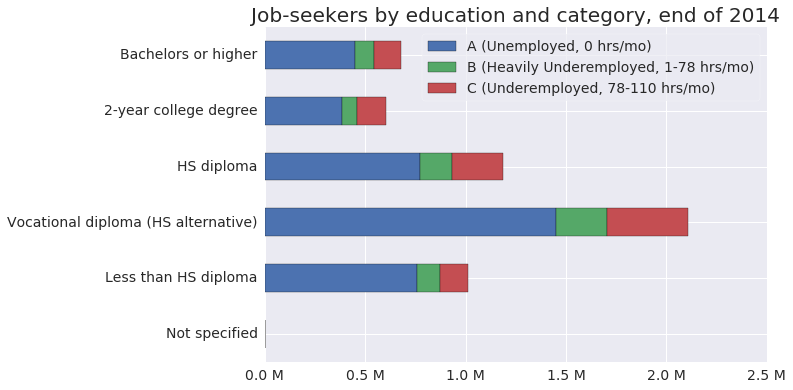

In [15]:
df = read_sheet('category x region x education', FILE_ANNUAL)
df = df.ix['France',:].unstack()
df = df.ix[:-1, :'C']
df.columns = [category_rename[c] for c in df.columns]
d = {
    u'Niveau inférieur au CAP': 'Less than HS diploma',
    u'Niveau CAP/BEP' : 'Vocational diploma (HS alternative)',
    u'Niveau BAC': 'HS diploma',
    u'Niveau BAC+2': '2-year college degree',
    u'Niveau supérieur à BAC+2': 'Bachelors or higher',
    u'Non précisé': 'Not specified',
}
order = [
    'Bachelors or higher',
    '2-year college degree',
    'HS diploma',
    'Vocational diploma (HS alternative)',
    'Less than HS diploma',
    'Not specified']
df.index = [d[i] for i in df.index]
df = df.ix[order,:]
fig, ax = plt.subplots(1)
df[::-1].plot(ax=ax, kind='barh', stacked=True, color=sns.color_palette())
normalize_xticklabels(ax)
ax.set_title('Job-seekers by education and category, end of 2014')
pass

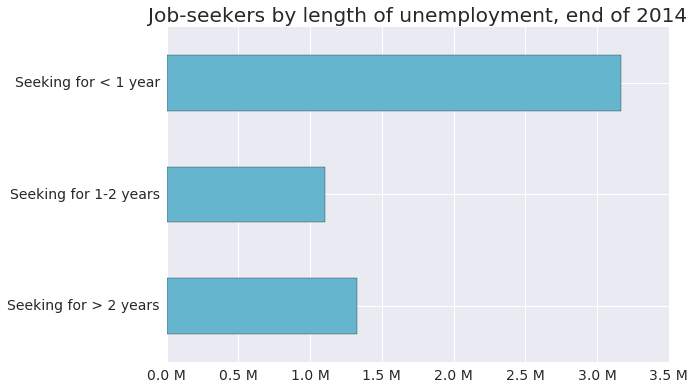

In [16]:
df = read_sheet('region x length of unemployment', FILE_ANNUAL)
s = df.ix['France', :-1]
d = collections.OrderedDict()
d[u'Moins de 1 an'] = 'Seeking for < 1 year'
d[u'De 1 an à moins de 2 ans'] = 'Seeking for 1-2 years'
d[u'2 ans ou plus'] = 'Seeking for > 2 years'
s.index=[d[x] for x in s.index]
s = s.ix[d.values()]
fig, ax = plt.subplots(1)
s[::-1].plot(kind='barh', color=sns.color_palette()[-1], ax=ax)
normalize_xticklabels(ax)
ax.set_title('Job-seekers by length of unemployment, end of 2014')
pass

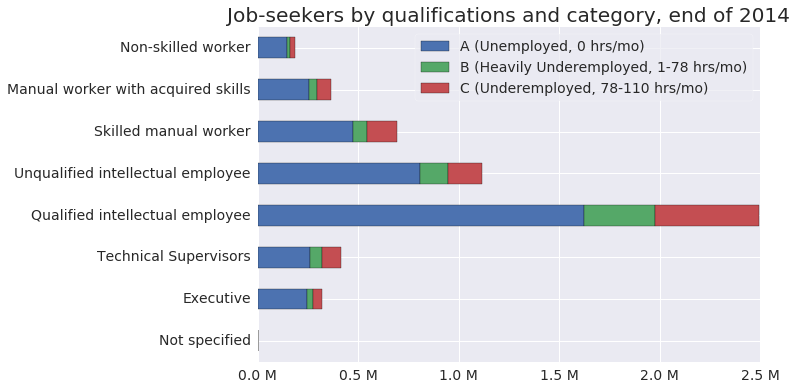

In [17]:
df = read_sheet('category x region x qualifications', FILE_ANNUAL)
df = df.ix['France',:].unstack()
df = df.ix[:-1, :'C']
df.columns = [category_rename[c] for c in df.columns]

d = collections.OrderedDict()
d[u'Manœuvre'] = 'Non-skilled worker'
d[u'Ouvrier spécialisé'] = 'Manual worker with acquired skills'
d[u'Ouvrier qualifié'] = 'Skilled manual worker'
d[u'Employé non qualifié'] = 'Unqualified intellectual employee'
d[u'Employé qualifié'] = 'Qualified intellectual employee'
d[u'Agent de maîtrise-Technicien-Dessinateur'] = 'Technical Supervisors'
d[u'Cadre'] = 'Executive'
d[u'Non précisé'] = 'Not specified'
df.index=[d[x] for x in df.index]
df = df.ix[d.values(),:]

fig, ax = plt.subplots(1)
df[::-1].plot(ax=ax, kind='barh', stacked=True, color=sns.color_palette())
normalize_xticklabels(ax)
ax.set_title('Job-seekers by qualifications and category, end of 2014')
pass

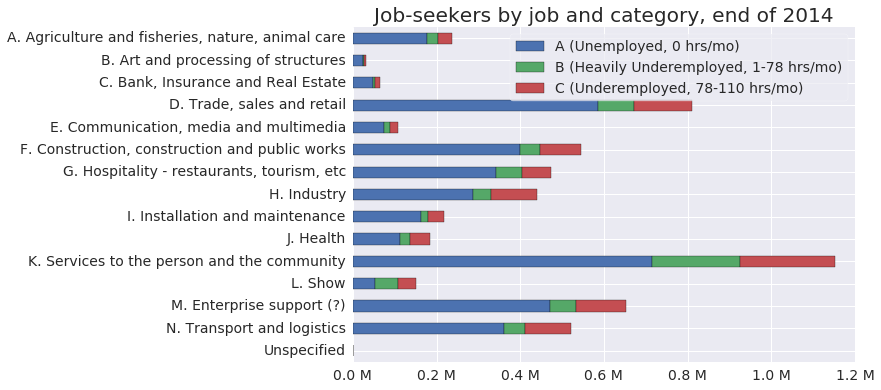

In [18]:
df = read_sheet('category x job x sex', FILE_ANNUAL)
df = df['Total'].ix[:-1, :'C']
df.columns = [category_rename[c] for c in df.columns]

df.index = [x.strip() for x in df.index]
d = collections.OrderedDict()
d[u"A. Agriculture et pêche, espaces naturels et espaces verts, soins aux animaux"] = "A. Agriculture and fisheries, nature, animal care"
d[u"B. Art  et façonnage d'ouvrages d'art"] = "B. Art and processing of structures"
d[u"C. Banque, assurances et immobilier"] = "C. Bank, Insurance and Real Estate"
d[u"D. Commerce, vente et grande distribution"] = "D. Trade, sales and retail"
d[u"E. Communication, media et multimédia"] = "E. Communication, media and multimedia"
d[u"F. Construction, bâtiment et travaux publics"] = "F. Construction, construction and public works"
d[u"G. Hôtellerie - restauration, tourisme, loisirs et animation"] = "G. Hospitality - restaurants, tourism, etc"
d[u"H. Industrie"] = "H. Industry"
d[u"I. Installation et maintenance"] = "I. Installation and maintenance"
d[u"J .Santé"] = "J. Health"
d[u"K. Services  a la personne et a la collectivité"] = "K. Services to the person and the community"
d[u"L. Spectacle"] = "L. Show"
d[u"M. Support a l'entreprise"] = "M. Enterprise support (?)"
d[u"N. Transport et logistique"] = "N. Transport and logistics"
d[u"Non précisé"] = "Unspecified"
df.index=[d[x] for x in df.index]
df = df.ix[d.values(),:]

fig, ax = plt.subplots(1)
df[::-1].plot(ax=ax, kind='barh', stacked=True, color=sns.color_palette())
normalize_xticklabels(ax)
ax.set_title('Job-seekers by job and category, end of 2014')
pass

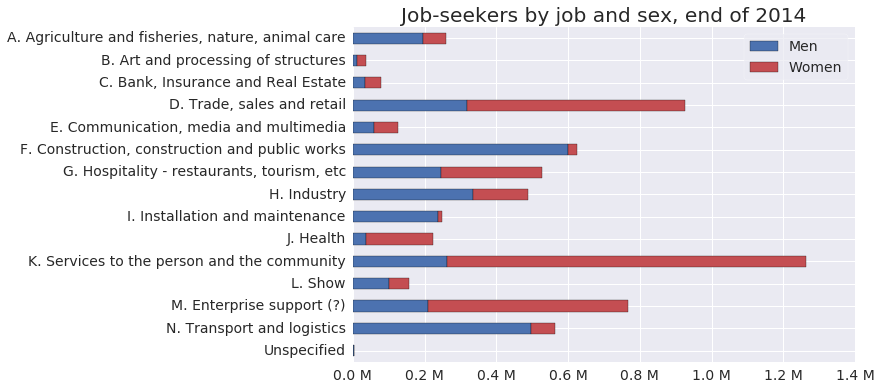

In [19]:
df = read_sheet('category x job x sex', FILE_ANNUAL)
df = df.ix[:-1,[('Hommes','Total'), ('Femmes','Total')]]
df.columns = ['Men', 'Women']
df.index = [x.strip() for x in df.index]
df.index=[d[x] for x in df.index]
df = df.ix[d.values(),:]

fig, ax = plt.subplots(1)
color = sns.color_palette()
df[::-1].plot(ax=ax, kind='barh', stacked=True, color=[color[0], color[2]])
normalize_xticklabels(ax)
ax.set_title('Job-seekers by job and sex, end of 2014')
pass

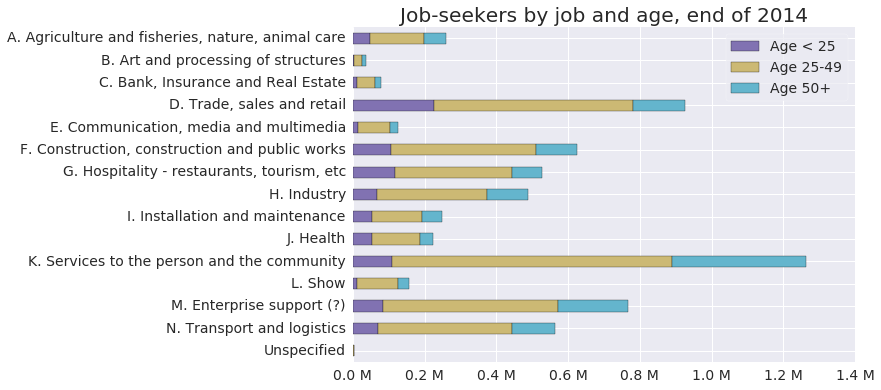

In [20]:
df = read_sheet('category x job x age', FILE_ANNUAL)
df = df.ix[:-1,[('Moins de 25 ans','Total'), ('25-49 ans','Total'), ('50 ans ou plus','Total')]]
df.columns = ['Age < 25', 'Age 25-49', 'Age 50+']
df.index = [x.strip() for x in df.index]
df.index=[d[x] for x in df.index]
df = df.ix[d.values(),:]

fig, ax = plt.subplots(1)
color = sns.color_palette()
df[::-1].plot(ax=ax, kind='barh', stacked=True, color=color[3:6])
normalize_xticklabels(ax)
ax.set_title('Job-seekers by job and age, end of 2014')
pass

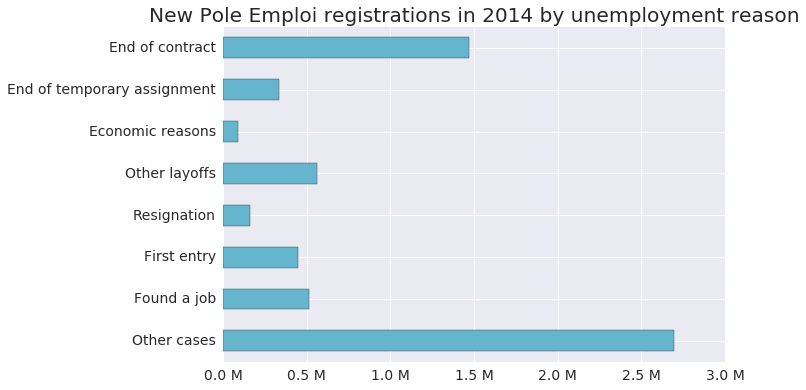

In [21]:
df = read_sheet('entries: region x reason', FILE_ANNUAL)
s = df.ix['France',:-1]

df.index = [x.strip() for x in df.index]
reasons = collections.OrderedDict()
reasons[u"Fins de contrat à durée déterminée"] = "End of contract"
reasons[u"Fins de mission d'intérim"] = "End of temporary assignment"
reasons[u"Licenciements économiques"] = "Economic reasons"
reasons[u"Autres licenciements"] = "Other layoffs"
reasons[u"Démissions"] = "Resignation"
reasons[u"Première entrée"] = "First entry"
reasons[u"Reprise d'activité"] = "Found a job"
reasons[u"Autre cas"] = "Other cases"

s.index=[reasons[x] for x in s.index]
s = s.ix[reasons.values()]

fig, ax = plt.subplots(1)
s[::-1].plot(ax=ax, kind='barh', stacked=True, color=sns.color_palette()[-1])
normalize_xticklabels(ax)
ax.set_title('New Pole Emploi registrations in 2014 by unemployment reason')
pass

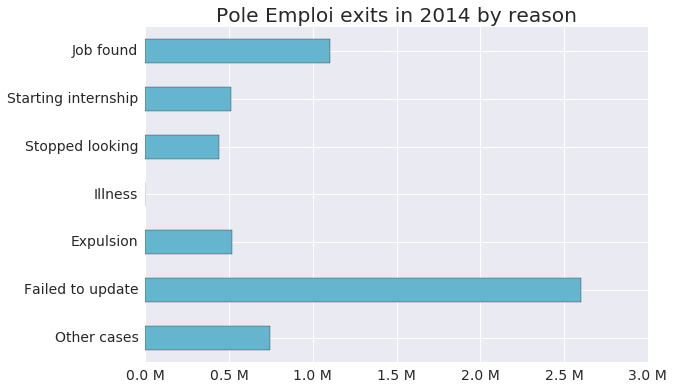

In [22]:
df = read_sheet('exits: region x reason', FILE_ANNUAL)
s = df.ix['France',:-1]

df.index = [x.strip() for x in df.index]
reasons_exit = collections.OrderedDict()
reasons_exit[u"Reprise d'emploi déclarée"] = "Job found"
reasons_exit[u"Entrée en stage"] = "Starting internship"
reasons_exit[u"Arrêt de recherche (maternité, maladie, retraite)"] = "Stopped looking"
reasons_exit[u"Arrêt maladie"] = "Illness"
reasons_exit[u"Radiation administrative"] = "Expulsion"
reasons_exit[u"Cessation d'inscription pour défaut d'actualisation"] = "Failed to update"
reasons_exit[u"Autre cas"] = "Other cases"

s.index=[reasons_exit[x] for x in s.index]
s = s.ix[reasons_exit.values()]

fig, ax = plt.subplots(1)
s[::-1].plot(ax=ax, kind='barh', stacked=True, color=sns.color_palette()[-1])
normalize_xticklabels(ax)
ax.set_title('Pole Emploi exits in 2014 by reason')
pass

---
## Explore monthly data
---

In [23]:
dfe = read_sheet('monthly entries: cat ABC by reason', FILE_MONTHLY)
dfe['Total'] = dfe[u"France métro.\n(catégories A,B,C)"] + dfe[u"DOM\n(catégories A,B,C)"]

In [24]:
dfs = read_sheet('monthly exits: cat ABC by reason', FILE_MONTHLY)
dfs['Total'] = dfs[u"France métro.\n(catégories A,B,C)"] + dfs[u"DOM\n(catégories A,B,C)"]

In [25]:
dfa = read_sheet('monthly: cat ABC by age x gender', FILE_MONTHLY)
population = dfa[('Total (DEFM ABC)', 'Ensemble')]

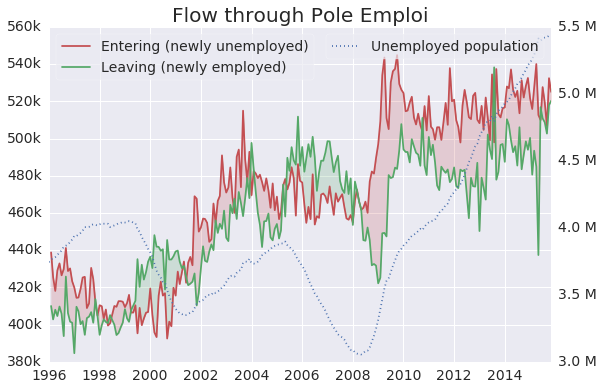

In [26]:
fig, ax = plt.subplots(1)
ax.plot(dfe['Total'], label='Entering (newly unemployed)', color=SNS_RED)
ax.plot(dfs['Total'], label='Leaving (newly employed)', color=SNS_GREEN)
normalize_yticklabels(ax)
ax.legend(loc='upper left')
ax.set_title('Flow through Pole Emploi')
df = pd.concat([dfe['Total'], dfs['Total']], axis=1)
ax.fill_between(dfe.index, dfe['Total'], df.min(axis=1), color=SNS_RED, alpha=0.2)
ax.fill_between(dfe.index, dfe['Total'], df.max(axis=1), color=SNS_GREEN, alpha=0.2)
ax2 = ax.twinx()
ax2.plot(population, color=SNS_BLUE, label='Unemployed population', linestyle=':')
ax2.legend(loc='upper right')
normalize_yticklabels(ax2)
ax2.grid()
pass

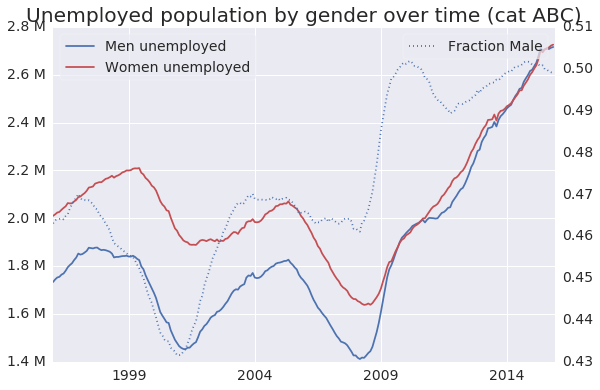

In [27]:
df = dfa[[('Hommes (DEFM ABC)', 'Ensemble'), ('Femmes (DEFM ABC)', 'Ensemble')]]
df.columns = ['Men', 'Women']
fig, ax = plt.subplots(1)

df['Men'].plot(ax=ax, color=SNS_BLUE, label='Men unemployed')
df['Women'].plot(ax=ax, color=SNS_RED, label='Women unemployed')
ax.set_xlabel('')
ax.set_title('Unemployed population by gender over time (cat ABC)')
ax.legend(loc='upper left')
normalize_yticklabels(ax)

ax2 = ax.twinx()
frac_male = df['Men'].div(df.sum(axis=1))
frac_male.plot(ax=ax2, label='Fraction Male', color=SNS_BLUE, linestyle=':')
ax2.legend(loc='upper right')
ax2.grid()

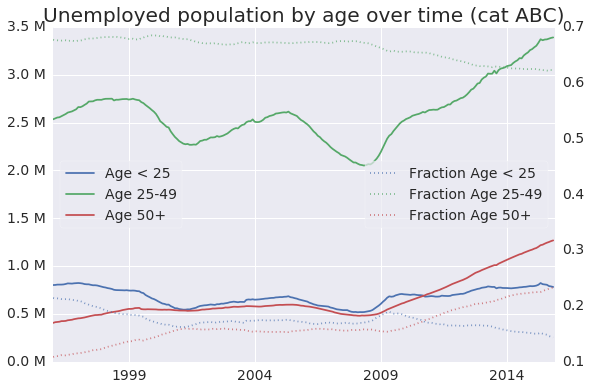

In [28]:
df = dfa['Total (DEFM ABC)'].drop('Ensemble', axis=1)
df.columns = ['Age < 25', 'Age 25-49', 'Age 50+']
fig, ax = plt.subplots(1)

df.plot(ax=ax)
ax.set_xlabel('')
ax.set_title('Unemployed population by age over time (cat ABC)')
ax.legend(loc='center left')
normalize_yticklabels(ax)

ax2 = ax.twinx()
frac = df.div(df.sum(axis=1), axis=0)
frac.head()
frac.columns = ['Fraction ' + c for c in frac.columns]
frac.plot(ax=ax2, linestyle=':', alpha=0.7)
ax2.legend(loc='center right')
ax2.grid()

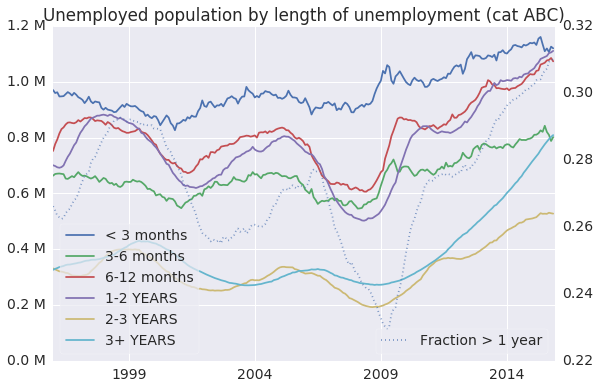

In [29]:
dfl = read_sheet('monthly: cat ABC by length of unemployment', FILE_MONTHLY)#, debug=True)
# For whatever reason, metropolitan France and DOM have different numbers of buckets.
# So we'll just look at metro France for now.
dfl = dfl[u"Ancienneté d'inscription en catégories A,B,C (France métropolitaine)"]
dfl = dfl.drop([''], axis=1)
dfl.columns = [u'< 3 months', u'3-6 months', u'6-12 months', u'1-2 YEARS', u'2-3 YEARS', u'3+ YEARS', '> 1 YEAR']
fig, ax = plt.subplots(1)

df = dfl.ix[:,:-1]
df.plot(ax=ax)
ax.set_xlabel('')
ax.set_title('Unemployed population by length of unemployment (cat ABC)', size='large')
ax.legend(loc='lower left')
normalize_yticklabels(ax)

ax2 = ax.twinx()
frac = dfl.div(dfl.sum(axis=1), axis=0)
frac['> 1 YEAR'].plot(ax=ax2, linestyle=':', alpha=0.7, label='Fraction > 1 year')
ax2.legend(loc='lower right')
ax2.grid()

In [30]:
#foo